In [295]:
!pip install opencv-python matplotlib imageio gdown tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [296]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
annotated-types           0.7.0
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.15.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2024.7.4
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.2
decorator                 5.1.1
defusedxml                0.7.1
executing                 2.0.1
fastapi                   0.112.0
fastjsonschema            2.20.0
filelock                  3.16.1
flatbuffers    

In [297]:
import os
import cv2
import tensorflow as tf
import numpy as np 
from typing import List 
from matplotlib import pyplot as plt 
import imageio

In [298]:
tf.config.list_physical_devices('GPU')

[]

In [299]:
physical_devices = tf.config.list_physical_devices('GPU')
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [300]:
import gdown

In [301]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=6b79ae9b-24ef-4c92-a491-f229db5453b7
To: C:\Users\prish\IdeaProjects\data.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████| 423M/423M [00:27<00:00, 15.4MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [302]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [303]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [304]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [305]:
#Tokenizes each character for encoding and calulcating loss
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] size =40)


In [306]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [307]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [308]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [309]:
# Converts raw string to a tensorflow function 
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [310]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [311]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

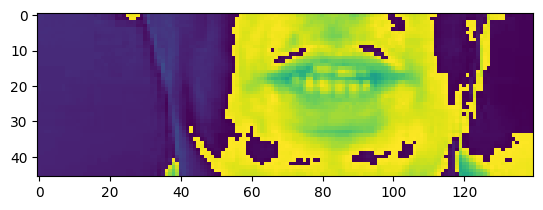

In [312]:
plt.imshow(frames[40])

In [313]:
#Need to perform a num_to_char decode
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [314]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [315]:
#Returns floats by implementing raw string processing (wrapped in a tf.py_function) 
from typing import Tuple
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result

Create a Data Pipeline

In [316]:
from matplotlib import pyplot as plt 

In [392]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
# two videos with two sets of alignments
data = data.padded_batch(2, padded_shapes=([75, 46, 140, 1], [40]))
#Preloading as the model is still learning, in order to optimize the data pipeline
data = data.prefetch(tf.data.AUTOTUNE)

#Split for test and train
train = data.take(300)
test = data.skip(300)

In [366]:
frames, alignments = data.as_numpy_iterator().next()

In [367]:
alignments

array([[12,  1, 25, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39,  1,
        39, 15, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39,  9, 14, 39,  2, 39,
        14,  9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [368]:
len(test)

50

In [369]:
len(frames)

2

In [370]:
sample = data.as_numpy_iterator()

In [371]:
val = sample.next(); val[0]

array([[[[[ 1.5771849 ],
          [ 1.5054947 ],
          [ 1.4696496 ],
          ...,
          [ 0.32260603],
          [ 0.32260603],
          [ 0.32260603]],

         [[ 1.5413399 ],
          [ 1.4696496 ],
          [ 1.5054947 ],
          ...,
          [ 0.32260603],
          [ 0.32260603],
          [ 0.32260603]],

         [[ 1.4338045 ],
          [ 1.4338045 ],
          [ 1.3979594 ],
          ...,
          [ 0.39429623],
          [ 0.32260603],
          [ 0.32260603]],

         ...,

         [[ 1.0395082 ],
          [ 1.0395082 ],
          [ 1.0395082 ],
          ...,
          [ 0.03584511],
          [ 0.03584511],
          [ 0.03584511]],

         [[ 1.0395082 ],
          [ 1.0395082 ],
          [ 1.0395082 ],
          ...,
          [ 0.03584511],
          [ 0.03584511],
          [ 0.03584511]],

         [[ 1.0395082 ],
          [ 1.0395082 ],
          [ 1.0395082 ],
          ...,
          [ 0.03584511],
          [ 0.03584511],
          

In [372]:
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)

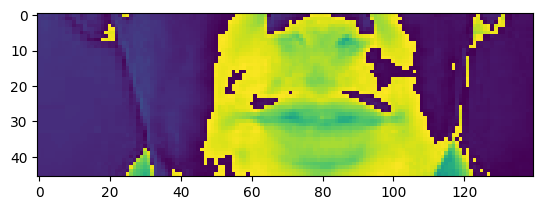

In [373]:
# imshow[videos][video][frame]
plt.imshow(val[0][0][35])

In [374]:
#Annotation for 
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u six please'>

Neural Network Architecture

In [375]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
# Allows to save the model after each epoch
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

**Benefits of Using a CTC**
Implementing a Connectionist Temporal Classification (CTC) Loss - it is a type of neural network output and associated scoring function used to train recurrent neural networks (RNNs) for sequence problems where the timing is variable. 

In this case, it is particularly useful for alignment-free training - CTC allows training without the need to pre-align input-output pairs.

Original Publication and Model: https://arxiv.org/pdf/1611.01599

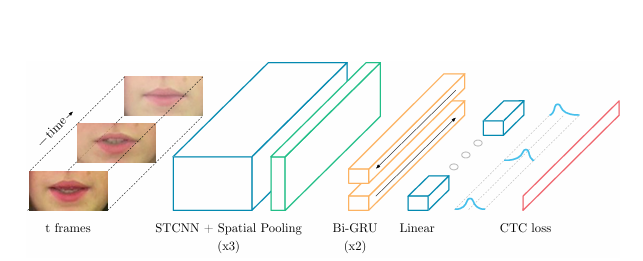

In [376]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [377]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

An LSTM cell consists of several components: input gate, forget gate, output gate, and a cell state. They are employed for learning long-term dependencies, and are a RNN used to solving the vanishing gradient problem.

In [378]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_14 (MaxPooling3D)      │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [379]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [380]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"rrrzznnnnnn''''''''nnnnnnnnnnnnnnnnnnnnnnnnnn'''''''''''''''''''??y?yy???pp">

In [381]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"rrrzznnnnnn''''''''nnnnnnnnnnnnnnnnnnnnnnnnnn'''''''''''''''''''??y?yy???pp">

In [382]:
model.input_shape

(None, 75, 46, 140, 1)

In [383]:
model.output_shape

(None, 75, 41)

**Training Options and Training**

In [384]:
# A learning rate scheduler is used to adjust the learning rate during the 
# training process to optimize the convergence of the model.
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [385]:
# Source: https://github.com/keras-team/keras-io/blob/master/examples/audio/ctc_asr.py
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [386]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        #Designed the applets of a CTC trained model
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [387]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [388]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [389]:
schedule_callback = LearningRateScheduler(scheduler)

In [390]:
example_callback = ProduceExample(test)

In [393]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
 20/300 ━━━━━━━━━━━━━━━━━━━━ 33:15 7s/step - loss: 120.2162

KeyboardInterrupt: 

**Utilize Model to Make Prediction**

In [394]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=aad95953-6675-4611-9a39-78054b5497a8
To: C:\Users\prish\IdeaProjects\checkpoints.zip
100%|███████████████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:08<00:00, 11.2MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [419]:
import os

# Verify file existence
if not os.path.exists('IdeaProjects/models/checkpoint'):
    print("File does not exist.")
else:
    print("File exists.")


File does not exist.


In [401]:
test_data = test.as_numpy_iterator()

In [402]:
sample = test_data.next()

In [403]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [404]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by m two please'>]

In [405]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [417]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b''>,
 <tf.Tensor: shape=(), dtype=string, numpy=b''>]